In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import bambi as bmb
import theano
import arviz as az
import os
cwd = os.getcwd() # Get direction
import warnings
warnings.filterwarnings('ignore')
import bayes_ame as ame
import bayes_r2 as r2

In [2]:
DF= pd.read_csv(cwd[:-4]+'/Data/data_farmclass_state.csv')

In [4]:
DF.loc[DF.insured_farms > 1, 'insured_farms'] = 1
DF['midpoint_farmsize']= (DF['lower_bound']+DF['upper_bound'])/2
DF.loc[DF['livestockfarm_share']== 0.0, 'livestockfarm_share']= 0.0010
DF.loc[DF['irrigated_farms']== 1.0, 'irrigated_farms']= 0.99

In [5]:
def dfsummary(trace):
    dfy= az.summary(trace)
    dfy['variables'] =dfy.index
    dfy['farm_class']= dfy.variables.str[-2:-1]
    
    return dfy

### Prepare data for Bayesian Models

In [6]:
## Remove inf vals
DF.replace([np.inf, -np.inf], np.nan, inplace=True)
## Selected variables for inference
norm_vars= ['midpoint_farmsize',
            'insured_farms','fed_income','state_income',
            'rented_land','labor_share','machinery_asset',
             'livestockfarm_share',
             'cropland_entropy','cropland_share',
              'erosion_rate', 'climate_ffp_full_year','climate_ffp_z_full_year',
              'climate_prec_growing_season','climate_prec_z_full_year']
DF1= DF[['year','Region_fips','farm_class','class','cover_crops','year_2017']+norm_vars]

## Standardize the complete sample except climate z values
for x in norm_vars:
    if x== 'climate_ffp_z_full_year' or x=='climate_prec_z_full_year':
        DF1[x+'_norm']= DF1[x]
    else:
        DF1[x+'_norm']= (np.log(DF1[x])- (np.log(DF1[x])).mean())/(np.log(DF1[x]).std())


# Pooled model

In [7]:
# Priors
priorsp = {
    'Intercept': bmb.Prior("Normal", mu= 0, sigma= 10),
    'midpoint_farmsize_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'insured_farms_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'fed_income_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'state_income_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'rented_land_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'machinery_asset_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'livestockfarm_share_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'cropland_entropy_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'cropland_share_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'erosion_rate_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'climate_ffp_full_year_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'climate_prec_growing_season_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'climate_ffp_z_full_year_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'climate_prec_z_full_year_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'year_2017': bmb.Prior('Laplace', mu= 0, b= 10)
}
## Pooled model
modelp = bmb.Model("cover_crops ~ 1+(midpoint_farmsize_norm)+\
                    (insured_farms_norm)+(fed_income_norm) + (state_income_norm)+\
                    (rented_land_norm)+(machinery_asset_norm)+\
                     (livestockfarm_share_norm) + \
                    (cropland_entropy_norm)+(cropland_share_norm)+\
                     (erosion_rate_norm) + (climate_ffp_full_year_norm) +\
                    (climate_prec_growing_season_norm)+(climate_ffp_z_full_year_norm)+\
                    (climate_prec_z_full_year_norm)+\
                    (year_2017)", 
                     DF1, family='beta', priors= priorsp, dropna=True)

Automatically removing 272/1146 rows from the dataset.


In [8]:
tracep = modelp.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cover_crops_kappa, Intercept, year_2017, climate_prec_z_full_year_norm, climate_ffp_z_full_year_norm, climate_prec_growing_season_norm, climate_ffp_full_year_norm, erosion_rate_norm, cropland_share_norm, cropland_entropy_norm, livestockfarm_share_norm, machinery_asset_norm, rented_land_norm, state_income_norm, fed_income_norm, insured_farms_norm, midpoint_farmsize_norm]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 92 seconds.


In [18]:
az.loo(tracep)

Computed from 4000 posterior samples and 874 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  1831.01    31.58
p_loo       19.32        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      874  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [19]:
dfp= dfsummary(tracep)
dfp

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm class
Intercept,-2.818,0.042,-2.895,-2.737,0.001,0.000,4653.0,2742.0,1.0,Intercept,p
midpoint_farmsize_norm,-0.410,0.048,-0.495,-0.319,0.001,0.001,3086.0,2685.0,1.0,midpoint_farmsize_norm,r
insured_farms_norm,0.388,0.041,0.314,0.466,0.001,0.001,2758.0,3065.0,1.0,insured_farms_norm,r
fed_income_norm,-0.253,0.032,-0.314,-0.192,0.001,0.000,2869.0,2637.0,1.0,fed_income_norm,r
state_income_norm,0.259,0.025,0.212,0.306,0.000,0.000,3888.0,3187.0,1.0,state_income_norm,r
rented_land_norm,0.102,0.044,0.021,0.181,0.001,0.001,2847.0,3149.0,1.0,rented_land_norm,r
machinery_asset_norm,0.074,0.034,0.010,0.137,0.001,0.000,2669.0,2780.0,1.0,machinery_asset_norm,r
livestockfarm_share_norm,-0.107,0.027,-0.159,-0.056,0.000,0.000,4038.0,2988.0,1.0,livestockfarm_share_norm,r
cropland_entropy_norm,0.107,0.027,0.057,0.157,0.001,0.000,2871.0,2885.0,1.0,cropland_entropy_norm,r
cropland_share_norm,-0.245,0.041,-0.321,-0.168,0.001,0.001,2517.0,2498.0,1.0,cropland_share_norm,r


In [9]:
selvars=['cons','midpoint_farmsize_norm',
         'insured_farms_norm','fed_income_norm','state_income_norm','rented_land_norm',
          'machinery_asset_norm','livestockfarm_share_norm',
         'cropland_entropy_norm','cropland_share_norm',
         'erosion_rate_norm','climate_ffp_full_year_norm',
         'climate_prec_growing_season_norm','climate_ffp_z_full_year_norm','climate_prec_z_full_year_norm',
         'year_2017']


varspost= ['Intercept','midpoint_farmsize_norm',
           'insured_farms_norm','fed_income_norm','state_income_norm',
           'rented_land_norm','machinery_asset_norm','livestockfarm_share_norm',
           'cropland_entropy_norm','cropland_share_norm',
            'erosion_rate_norm','climate_ffp_full_year_norm',
            'climate_prec_growing_season_norm','climate_ffp_z_full_year_norm',
           'climate_prec_z_full_year_norm',
           'year_2017']

DF1_clean= DF1
DF1_clean.dropna(axis=0, how='any',subset=['cover_crops','midpoint_farmsize_norm','insured_farms_norm','fed_income_norm','state_income_norm','rented_land_norm',
          'machinery_asset_norm','livestockfarm_share_norm',
         'cropland_entropy_norm','cropland_share_norm',
         'erosion_rate_norm','climate_ffp_full_year_norm','climate_ffp_z_full_year_norm',
         'climate_prec_growing_season_norm', 'year_2017'], inplace=True)


h= 0.0010 #scalar
DFamep= ame.ame_pooled(DF1_clean, tracep, selvars, varspost, h)

In [10]:
DFamep

,AME,std,CI25,CI97
cons,0.056370,2.082860e-17,0.056370,0.056370
midpoint_farmsize_norm,-0.024658,8.906597e-03,-0.047661,-0.011646
insured_farms_norm,0.023315,8.421088e-03,0.011012,0.045064
fed_income_norm,-0.015188,5.485823e-03,-0.029356,-0.007173
state_income_norm,0.015576,5.625851e-03,0.007357,0.030106
rented_land_norm,0.006117,2.209298e-03,0.002889,0.011823
machinery_asset_norm,0.004431,1.600386e-03,0.002093,0.008564
livestockfarm_share_norm,-0.006423,2.320169e-03,-0.012416,-0.003034
cropland_entropy_norm,0.006446,2.328115e-03,0.003044,0.012458
cropland_share_norm,-0.014741,5.324595e-03,-0.028493,-0.006962


In [14]:
meanp, lcip, ucip= r2.Bayesian_Rsquared(DF1_clean, tracep, 'cover_crops',selvars,varspost, False, x,4,1000,x)

In [17]:
print('Mean CI:', meanp)
print('Lower CI:', lcip)
print('Upper CI:', ucip)

Mean CI: 0.3086682727427701
Lower CI: 0.2636778383700524
Upper CI: 0.35477540846481603


# Hierarchical model 

In [18]:
#st_sd= bmb.Prior("HalfCauchy", beta= 1)
st_sd = 10

priorsc = {
    '1|class': bmb.Prior("Normal", mu= 0, sigma= st_sd),
    'insured_farms_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'fed_income_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'state_income_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'rented_land_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'machinery_asset_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'livestockfarm_share_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'cropland_entropy_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'cropland_share_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'erosion_rate_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'climate_ffp_full_year_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'climate_prec_growing_season_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'climate_ffp_z_full_year_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'climate_prec_z_full_year_norm|class':bmb.Prior("Laplace", mu= 0, b= st_sd),
    'year_2017|class': bmb.Prior('Laplace', mu= 0, b= st_sd)
}


In [19]:
model = bmb.Model("cover_crops ~ 0+(1|class)+\
                    (insured_farms_norm|class)+(fed_income_norm|class) + (state_income_norm|class)+\
                    (rented_land_norm|class) + (machinery_asset_norm|class)+\
                     (livestockfarm_share_norm|class) + \
                    (cropland_entropy_norm|class)+ (cropland_share_norm|class)+\
                     (erosion_rate_norm|class) + (climate_ffp_full_year_norm|class) +\
                    (climate_prec_growing_season_norm|class)+ (climate_ffp_z_full_year_norm|class)+\
                    (climate_prec_z_full_year_norm|class)+\
                    (year_2017|class)", 
                     DF1, family='beta', priors= priorsc, dropna=True)
#
model

Formula: cover_crops ~ 0+(1|class)+                    (insured_farms_norm|class)+(fed_income_norm|class) + (state_income_norm|class)+                    (rented_land_norm|class) + (machinery_asset_norm|class)+                     (livestockfarm_share_norm|class) +                     (cropland_entropy_norm|class)+ (cropland_share_norm|class)+                     (erosion_rate_norm|class) + (climate_ffp_full_year_norm|class) +                    (climate_prec_growing_season_norm|class)+ (climate_ffp_z_full_year_norm|class)+                    (climate_prec_z_full_year_norm|class)+                    (year_2017|class)
Family name: Beta
Link: logit
Observations: 874
Priors:
  Group-level effects
    1|class ~ Normal(mu: 0, sigma: 10)
    insured_farms_norm|class ~ Laplace(mu: 0, b: 10)
    fed_income_norm|class ~ Laplace(mu: 0, b: 10)
    state_income_norm|class ~ Laplace(mu: 0, b: 10)
    rented_land_norm|class ~ Laplace(mu: 0, b: 10)
    machinery_asset_norm|class ~ Laplace(mu: 0, b: 1

In [20]:
trace = model.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cover_crops_kappa, year_2017|class, climate_prec_z_full_year_norm|class, climate_ffp_z_full_year_norm|class, climate_prec_growing_season_norm|class, climate_ffp_full_year_norm|class, erosion_rate_norm|class, cropland_share_norm|class, cropland_entropy_norm|class, livestockfarm_share_norm|class, machinery_asset_norm|class, rented_land_norm|class, state_income_norm|class, fed_income_norm|class, insured_farms_norm|class, 1|class]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 109 seconds.


In [15]:
df= dfsummary(trace)
df[df['farm_class']== '0']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm class
1|class[0],-2.582,0.086,-2.743,-2.423,0.002,0.001,2459.0,2728.0,1.0,1|class[0],0
insured_farms_norm|class[0],0.271,0.068,0.143,0.397,0.001,0.001,2507.0,3087.0,1.0,insured_farms_norm|class[0],0
fed_income_norm|class[0],-0.290,0.052,-0.386,-0.192,0.001,0.001,2688.0,3246.0,1.0,fed_income_norm|class[0],0
state_income_norm|class[0],0.078,0.038,0.005,0.148,0.001,0.000,4530.0,3222.0,1.0,state_income_norm|class[0],0
rented_land_norm|class[0],0.025,0.058,-0.094,0.126,0.001,0.001,3617.0,2799.0,1.0,rented_land_norm|class[0],0
machinery_asset_norm|class[0],0.054,0.055,-0.054,0.152,0.001,0.001,2660.0,2780.0,1.0,machinery_asset_norm|class[0],0
livestockfarm_share_norm|class[0],-0.007,0.069,-0.132,0.125,0.001,0.001,3644.0,3165.0,1.0,livestockfarm_share_norm|class[0],0
cropland_entropy_norm|class[0],0.041,0.045,-0.040,0.127,0.001,0.001,3163.0,3161.0,1.0,cropland_entropy_norm|class[0],0
cropland_share_norm|class[0],-0.158,0.073,-0.294,-0.023,0.001,0.001,2479.0,2920.0,1.0,cropland_share_norm|class[0],0
erosion_rate_norm|class[0],0.113,0.053,0.013,0.212,0.001,0.001,3579.0,3471.0,1.0,erosion_rate_norm|class[0],0


In [16]:
df[df['farm_class']== '1']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm class
1|class[1],-2.864,0.084,-3.030,-2.715,0.002,0.001,2516.0,2638.0,1.0,1|class[1],1
insured_farms_norm|class[1],0.242,0.077,0.101,0.388,0.001,0.001,2930.0,3215.0,1.0,insured_farms_norm|class[1],1
fed_income_norm|class[1],-0.332,0.065,-0.452,-0.210,0.001,0.001,2405.0,2800.0,1.0,fed_income_norm|class[1],1
state_income_norm|class[1],0.218,0.050,0.125,0.314,0.001,0.001,4324.0,2850.0,1.0,state_income_norm|class[1],1
rented_land_norm|class[1],0.145,0.104,-0.060,0.330,0.002,0.001,3272.0,3338.0,1.0,rented_land_norm|class[1],1
machinery_asset_norm|class[1],0.151,0.073,0.007,0.281,0.002,0.001,2056.0,2370.0,1.0,machinery_asset_norm|class[1],1
livestockfarm_share_norm|class[1],-0.213,0.070,-0.347,-0.085,0.001,0.001,3526.0,3200.0,1.0,livestockfarm_share_norm|class[1],1
cropland_entropy_norm|class[1],0.141,0.052,0.042,0.238,0.001,0.001,2915.0,2668.0,1.0,cropland_entropy_norm|class[1],1
cropland_share_norm|class[1],-0.146,0.087,-0.312,0.012,0.002,0.001,2755.0,2422.0,1.0,cropland_share_norm|class[1],1
erosion_rate_norm|class[1],0.252,0.062,0.137,0.370,0.001,0.001,3924.0,3039.0,1.0,erosion_rate_norm|class[1],1


In [17]:
df[df['farm_class']== '2']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm class
1|class[2],-3.272,0.105,-3.470,-3.079,0.002,0.001,3169.0,2968.0,1.0,1|class[2],2
insured_farms_norm|class[2],0.247,0.085,0.095,0.413,0.001,0.001,3296.0,3377.0,1.0,insured_farms_norm|class[2],2
fed_income_norm|class[2],-0.306,0.059,-0.425,-0.200,0.001,0.001,3686.0,3100.0,1.0,fed_income_norm|class[2],2
state_income_norm|class[2],0.545,0.040,0.473,0.621,0.001,0.000,4090.0,3159.0,1.0,state_income_norm|class[2],2
rented_land_norm|class[2],0.240,0.095,0.071,0.425,0.002,0.001,3184.0,3018.0,1.0,rented_land_norm|class[2],2
machinery_asset_norm|class[2],0.017,0.069,-0.109,0.149,0.001,0.001,2800.0,2918.0,1.0,machinery_asset_norm|class[2],2
livestockfarm_share_norm|class[2],-0.050,0.034,-0.112,0.013,0.001,0.000,3851.0,3088.0,1.0,livestockfarm_share_norm|class[2],2
cropland_entropy_norm|class[2],0.141,0.049,0.051,0.236,0.001,0.001,3058.0,3159.0,1.0,cropland_entropy_norm|class[2],2
cropland_share_norm|class[2],-0.190,0.066,-0.304,-0.059,0.001,0.001,2721.0,3053.0,1.0,cropland_share_norm|class[2],2
erosion_rate_norm|class[2],0.148,0.051,0.051,0.246,0.001,0.001,3238.0,3294.0,1.0,erosion_rate_norm|class[2],2


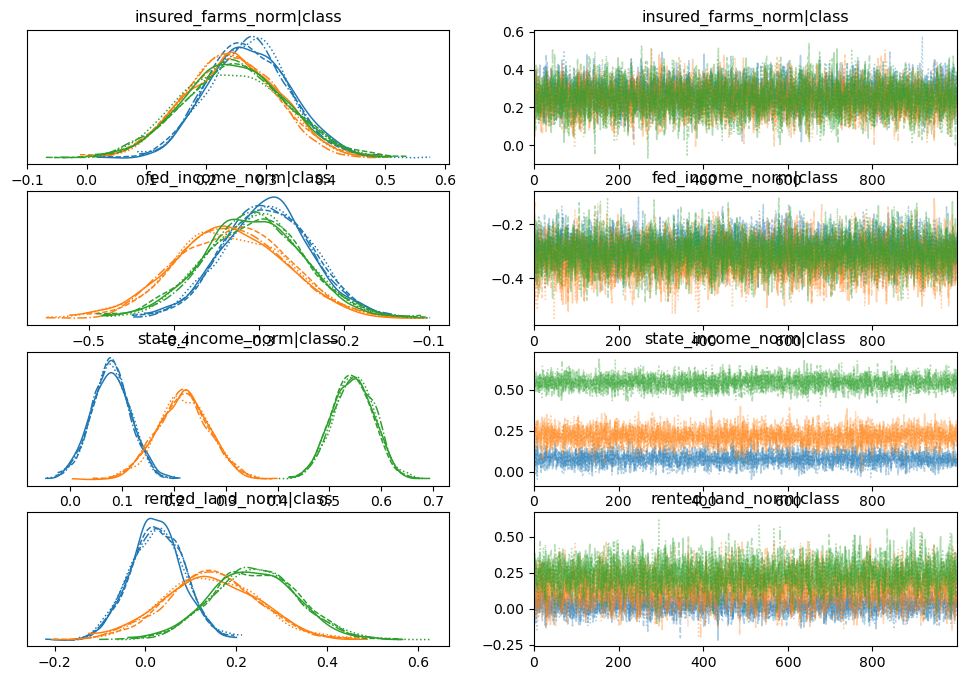

In [12]:
az.plot_trace(trace, var_names=['insured_farms_norm|class','fed_income_norm|class','state_income_norm|class','rented_land_norm|class'], compact=True);

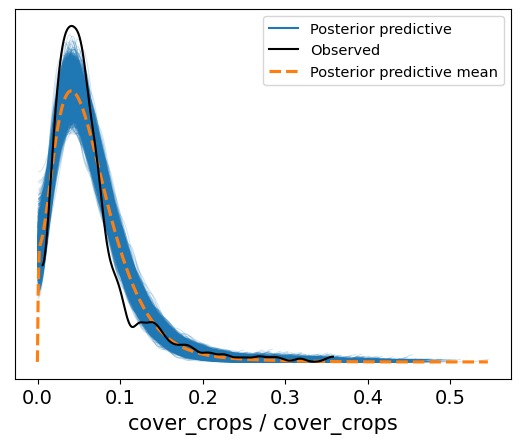

In [13]:
model.predict(trace, kind="pps")
az.plot_ppc(trace);

In [14]:
az.loo(trace)

Computed from 4000 posterior samples and 874 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  1853.76    30.81
p_loo       50.74        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      868   99.3%
 (0.5, 0.7]   (ok)          5    0.6%
   (0.7, 1]   (bad)         1    0.1%
   (1, Inf)   (very bad)    0    0.0%

## Average Marginal Effects 

In [21]:
selvars=['cons',
         'insured_farms_norm','fed_income_norm','state_income_norm','rented_land_norm',
          'machinery_asset_norm','livestockfarm_share_norm',
         'cropland_entropy_norm','cropland_share_norm',
         'erosion_rate_norm','climate_ffp_full_year_norm',
         'climate_prec_growing_season_norm','climate_ffp_z_full_year_norm','climate_prec_z_full_year_norm',
         'year_2017']


varspost= ['1|class','insured_farms_norm|class','fed_income_norm|class','state_income_norm|class',
           'rented_land_norm|class','machinery_asset_norm|class','livestockfarm_share_norm|class',
           'cropland_entropy_norm|class','cropland_share_norm|class',
            'erosion_rate_norm|class','climate_ffp_full_year_norm|class',
            'climate_prec_growing_season_norm|class','climate_ffp_z_full_year_norm|class',
           'climate_prec_z_full_year_norm|class',
           'year_2017|class']

DF1_clean= DF1.copy()
DF1_clean.dropna(axis=0, how='any',subset=['cover_crops','insured_farms_norm','fed_income_norm','state_income_norm','rented_land_norm',
          'machinery_asset_norm','livestockfarm_share_norm',
         'cropland_entropy_norm', 'cropland_share_norm',
         'erosion_rate_norm','climate_ffp_full_year_norm','climate_ffp_z_full_year_norm',
         'climate_prec_growing_season_norm','climate_prec_z_full_year_norm',
                                           'year_2017'], inplace=True)


h= 0.001 #scalar
DFame= ame.ame_multilevel(DF1_clean, trace, selvars, varspost, h, 'farm_class', 3, ['Small','Medium', 'Large'])


In [22]:
DFame

,AME,std,CI25,CI97,farm_class
cons,0.070291,1.390145e-17,0.070291,0.070291,Small
insured_farms_norm,0.016652,4.064503e-03,0.011024,0.026672,Small
fed_income_norm,-0.017806,4.346536e-03,-0.028522,-0.011789,Small
state_income_norm,0.004788,1.168610e-03,0.003170,0.007669,Small
rented_land_norm,0.001561,3.809144e-04,0.001033,0.002500,Small
machinery_asset_norm,0.003335,8.140848e-04,0.002208,0.005342,Small
livestockfarm_share_norm,-0.000454,1.108278e-04,-0.000727,-0.000301,Small
cropland_entropy_norm,0.002491,6.080303e-04,0.001649,0.003990,Small
cropland_share_norm,-0.009717,2.371962e-03,-0.015565,-0.006433,Small
erosion_rate_norm,0.006925,1.690239e-03,0.004584,0.011092,Small


In [23]:
mean, lci, uci= r2.Bayesian_Rsquared(DF1_clean, trace, 'cover_crops',selvars,varspost, True, 'class', 4, 1000, 3)
print('Mean CI:', meanp)
print('Lower CI:', lcip)
print('Upper CI:', ucip)

Mean CI: 0.3086682727427701
Lower CI: 0.2636778383700524
Upper CI: 0.35477540846481603


### Model comparison

In [24]:
az.compare({"main": trace, "pooled": tracep})#, 'state effects': trace_cc2})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
main,0,1853.762706,50.744731,0.000000,0.580603,30.814374,0.000000,True,log
pooled,1,1831.007373,19.319779,22.755334,0.419397,31.576840,18.568951,False,log


In [25]:
print('Lower Bound: ', 22.755334-18.568951*2.92)
print('Upper Bound: ', 22.755334+18.568951*2.92)


Lower Bound:  -31.46600291999999
Upper Bound:  76.97667091999999


In [133]:
#ppc = pm.sample_posterior_predictive(trace_cc, samples=1000, model=modelcc)
#post_samples = np.asarray(ppc['cover_crops'])